In [38]:
import mpld3
mpld3.enable_notebook()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings ("ignore")

In [95]:
df = pd.read_csv('sample.csv', usecols=[0,9])
df.rename(columns = {"'Time and date'":'Time',"'ABP'":'ABP'}, inplace = True)
df['Time']=df['Time'].apply(lambda x: x.replace('[','').replace(']',''))
df.Time = pd.to_datetime(df.Time)
df=df.set_index('Time')

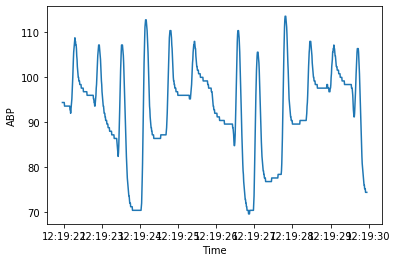

In [101]:
data=df[:1000]
train  =data[:800]
test=data[-200:]
scaler=MinMaxScaler()
train=scaler.fit_transform(train)
test= scaler.fit_transform(test)
plt.plot(data)
plt.ylabel('ABP')
plt.xlabel('Time')
plt.show()                               

In [102]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [103]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [104]:
look_back=3
train_data_gen = TimeseriesGenerator(train, train, length=look_back, sampling_rate=1,stride=1,batch_size=3)
test_data_gen = TimeseriesGenerator(test, test,length=look_back, sampling_rate=1,stride=1,batch_size=1)

In [105]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))#one output value
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_data_gen, epochs=100).history

Epoch 1/100
266/266 [==============================] - 1s 2ms/step - loss: 0.0785
Epoch 2/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 3/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 4/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 5/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 6/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 7/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 8/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 9/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 10/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 11/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 12/100
266/266 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 13/100


Epoch 97/100
266/266 [==============================] - 0s 1ms/step - loss: 1.3986e-04
Epoch 98/100
266/266 [==============================] - 0s 1ms/step - loss: 1.4055e-04
Epoch 99/100
266/266 [==============================] - 0s 1ms/step - loss: 1.4248e-04
Epoch 100/100
266/266 [==============================] - 0s 1ms/step - loss: 1.3609e-04


In [106]:
model.evaluate_generator(test_data_gen)
trainPredict = model.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model.predict_generator(test_data_gen)#
#testPredict.shape
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [107]:
testPredict

array([[ 92.81653 ],
       [ 94.865005],
       [ 95.39398 ],
       [ 97.168304],
       [100.207016],
       [101.489334],
       [103.98961 ],
       [105.29334 ],
       [106.60981 ],
       [106.9907  ],
       [108.72563 ],
       [108.19715 ],
       [107.82801 ],
       [107.82801 ],
       [106.673225],
       [105.66782 ],
       [104.84639 ],
       [104.0255  ],
       [101.98702 ],
       [101.35678 ],
       [100.75674 ],
       [ 99.94531 ],
       [ 99.136894],
       [ 99.59274 ],
       [ 98.57    ],
       [ 98.79776 ],
       [ 99.037415],
       [ 99.037415],
       [ 97.77315 ],
       [ 98.00558 ],
       [ 98.24998 ],
       [ 98.24998 ],
       [ 98.24998 ],
       [ 98.24998 ],
       [ 98.24998 ],
       [ 96.97967 ],
       [ 97.21624 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.46517 ],
       [ 97.4

In [108]:
trainY = get_y_from_generator(train_data_gen)
testY = get_y_from_generator(test_data_gen)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

(797, 1)
(197, 1)


In [109]:
from sklearn.metrics import mean_squared_error
import math
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.36 RMSE
Test Score: 0.47 RMSE


In [110]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Delta + previous close
trainPredictPlot = trainPredictPlot + data
# set empty values
# trainPredictPlot[0:look_back, :] = np.nan
# trainPredictPlot[len(trainPredict)+look_back:, :] = np.nan

In [111]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(data), :] = testPredict

# Delta + previous close
testPredictPlot = testPredictPlot + data
# set empty values
# testPredictPlot[0:len(trainPredict)+(look_back*2), :] = np.nan
# testPredictPlot[len(dataset):, :] = np.nan

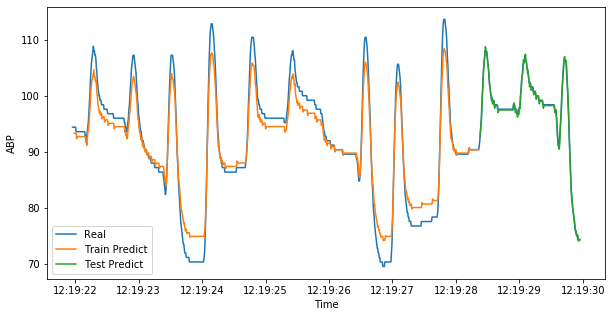

In [120]:
# plot baseline and predictions
fig = plt.figure(figsize=(10, 5))

plt.plot(data+data-data,label='Real')
plt.plot(trainPredictPlot-data,label='Train Predict')
plt.plot(testPredictPlot-data,label="Test Predict")
plt.legend()
plt.xlabel("Time")
plt.ylabel("ABP")
plt.show()

In [ ]:
plt.plot(data )
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()